Accuracy (AdaBoost from scratch): 0.9649122807017544


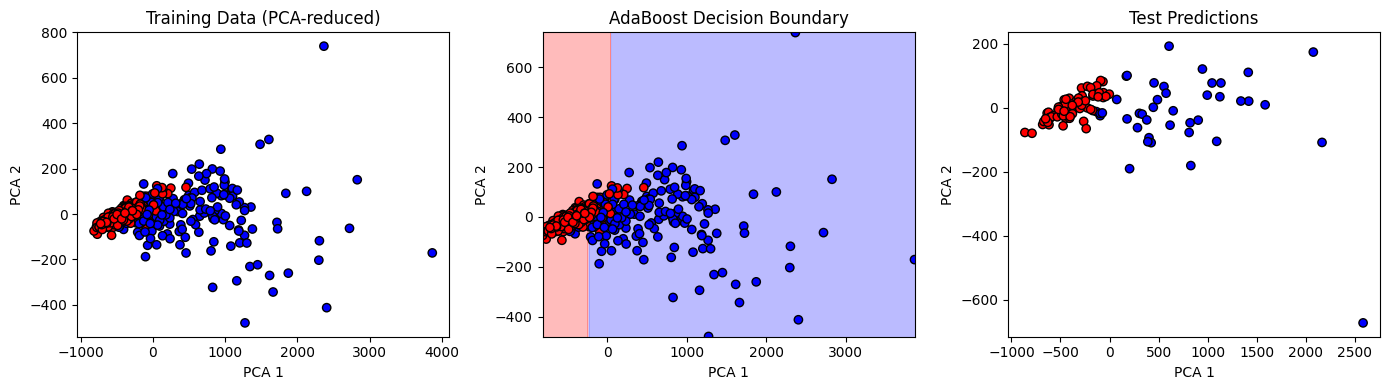

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target
y = np.where(y == 0, -1, 1)

# PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X)

# Split using the reduced 2D data
X_train, X_test, y_train, y_test = train_test_split(X_2D, y, test_size=0.2, random_state=42)

# ----- Decision Stump -----
class DecisionStump:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.polarity = 1
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X[:, self.feature_index] < self.threshold] = -1
        else:
            predictions[X[:, self.feature_index] > self.threshold] = -1
        return predictions

# ----- AdaBoost -----
def adaboost(X, y, n_estimators=20):
    n_samples, n_features = X.shape
    weights = np.full(n_samples, 1 / n_samples)
    stumps = []

    for _ in range(n_estimators):
        stump = DecisionStump()
        min_error = float('inf')

        for feature_i in range(n_features):
            feature_values = X[:, feature_i]
            thresholds = np.unique(feature_values)
            for threshold in thresholds:
                for polarity in [1, -1]:
                    predictions = np.ones(n_samples)
                    if polarity == 1:
                        predictions[feature_values < threshold] = -1
                    else:
                        predictions[feature_values > threshold] = -1

                    error = np.sum(weights[y != predictions])

                    if error < min_error:
                        min_error = error
                        stump.polarity = polarity
                        stump.threshold = threshold
                        stump.feature_index = feature_i

        EPS = 1e-10
        stump.alpha = 0.5 * np.log((1.0 - min_error) / (min_error + EPS))
        predictions = stump.predict(X)
        weights *= np.exp(-stump.alpha * y * predictions)
        weights /= np.sum(weights)

        stumps.append(stump)

    return stumps

def predict(X, stumps):
    stump_preds = [stump.alpha * stump.predict(X) for stump in stumps]
    y_pred = np.sign(np.sum(stump_preds, axis=0))
    return y_pred

# Train AdaBoost
stumps = adaboost(X_train, y_train, n_estimators=20)

# Predict
y_pred = predict(X_test, stumps)
acc = accuracy_score(y_test, y_pred)
print("Accuracy (AdaBoost from scratch):", acc)

# ----- Visualization -----

# Plot training data
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.title("Training Data (PCA-reduced)")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', edgecolor='k')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

# Decision boundary
plt.subplot(1, 3, 2)
plt.title("AdaBoost Decision Boundary")

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = predict(grid, stumps)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', edgecolor='k')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

# Test predictions
plt.subplot(1, 3, 3)
plt.title("Test Predictions")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='bwr', edgecolor='k')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()
